In [1]:
import numpy  as np
import pandas as pd
import pylab as pl
import os, psutil # used to monitor memory usage
from   glob import glob
from   astropy.table import Table
from   astropy.io import fits
import corner

from   tqdm import tqdm

pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

In [2]:
import torch
from   torch              import nn
from   torch              import FloatTensor
from   torch.utils.data   import Dataset
from   torch.utils.data   import DataLoader
from   torch.nn           import functional as F
from   torchvision        import transforms, models
#from   torchvision.models import vit_l_16, ViT_L_16_Weights
#from   torchvision.models import vit_l_32, ViT_L_32_Weights
from   torchvision.models import swin_b, Swin_B_Weights
from   torchvision.models import swin_s, Swin_S_Weights
from   torchvision.models import swin_t, Swin_T_Weights
from   torchvision.models import resnet18, ResNet18_Weights
from   torchvision.models import resnet50, ResNet50_Weights
from   torchvision.models import resnet152, ResNet152_Weights

from   sklearn.metrics    import r2_score
from   sklearn.metrics    import mean_squared_error

from   scipy.stats import gaussian_kde
from   scipy.optimize import curve_fit

In [3]:
from src.utils import mw_transmission
from src.utils import mag
from src.utils import metrics

In [4]:
class ReadDataset(Dataset):
    def __init__(self, data_paths, data):
        self.data_files = data_paths 
        self.data = data
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        TID = int(self.data_files[index].split('/')[-1].split('_')[1])
        #print(TID)
        #print(self.data_files[index])
        x = fits.open(self.data_files[index])
        #print(x)
        x = x[4].data
        #print(x, type(x))
        x = self.data_transforms(x)
        #print(x)
        
        y = np.array(self.data['Z'][self.data['TARGETID']==TID], dtype=float)[0]
        y = torch.tensor(y).float()
        #print(x,y)
        return x, y
    
    def __len__(self):
        return len(self.data_files)

In [5]:
class GalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, modelname='swins', lf=0):
        super().__init__()
        #print('hiii', model)
        if modelname=='vitl16':
            model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)
        elif modelname=='vitl32':
            model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT)
        elif modelname=='swinb':
            model = swin_b(weights=Swin_B_Weights.DEFAULT)
        elif modelname=='swins':
            model = swin_s(weights=Swin_S_Weights.DEFAULT)
        elif modelname=='swint':
            model = swin_t(weights=Swin_T_Weights.DEFAULT)
        elif modelname=='resnet18':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif modelname=='resnet50':
            model = resnet50(weights=ResNet50_Weights.DEFAULT)
        elif modelname=='resnet152':
            model = resnet152(weights=ResNet152_Weights.DEFAULT)

        else:
            print('Other model doesnt exist')
        
        count = 0
        #print(model)
        for child in model.children():  
            count += 1
            if count <= lf:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        model.load_state_dict(model.state_dict())     
        
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        if 'swin' in modelname:
            self.fc1 = torch.nn.Linear(model.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'vit' in modelname:
            self.fc1 = torch.nn.Linear(model.heads.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'resnet' in modelname:
            self.fc1 = torch.nn.Linear(model.fc.in_features, 512)
            self.fc2 = torch.nn.Linear(512, 256)

        self.fc3 = torch.nn.Linear(256, 1)        
        
    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [6]:
def evaluate(test_dataloader, model):
    with torch.no_grad():
        Y_pred = []
        Y_test = []
        # pbar = tqdm(total=len(test_dataloader))
        for batch_idx, (imgdata, target) in enumerate(test_dataloader):
            #data   = FloatTensor(data)
            #target = FloatTensor(target)
            imgdata = imgdata.to(device)
            target  = target.to(device)
            Y_pred.append(model(imgdata).cpu().squeeze().detach().numpy())
            Y_test.append(target.cpu().detach().numpy())
        #     pbar.update()
        # pbar.close()
        Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
        Y_test     = np.concatenate([np.ravel(i) for i in Y_test])
        
        return Y_predtest, Y_test
        
def model_plot(Y_predtest, Y_test, outpath, figname, density=False):
        ii_z = Y_test<0.6
        Z = gaussian_kde(np.vstack([Y_test, Y_predtest]))(np.vstack([Y_test, Y_predtest]))
        idx = Z.argsort()
        x, y, z = Y_test[idx], Y_predtest[idx], Z[idx]
        
        error = 0.05
        bias, sigma_nmad, f_out = metrics(Y_test, Y_predtest, error)

        fig = pl.figure(figsize=(8,6), rasterized=True)
        pl.scatter(x, y, c=z, s=0.1, cmap='jet', marker='.')
        pl.ylabel(r'$z_{photo}$', fontsize=20)
        pl.xlabel(r'$z_{spec}$', fontsize=20)
        pl.colorbar()
        pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), ls='-', c='black')
        pl.plot(np.linspace(0,2,5)+error, np.linspace(0,2,5), '--k', alpha=0.8)
        pl.plot(np.linspace(0,2,5), np.linspace(0,2,5)+error, '--k', alpha=0.8)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
        text_box = r'$\sigma_{NMAD}$ = '+f'{sigma_nmad:.4f}\n'+r'$f_{out}$ = '+f'{f_out:.2f}%\n'+r'$\left<\frac{\Delta z}{1+ z_{spec}}\right>$ = 'f'{np.average(bias):.4f}\n'+r'$r^2$ = 'f'{r2_score(Y_test, Y_predtest):.3f}'
        pl.text(0.013, 0.57, text_box, fontsize=15, verticalalignment='top', bbox=props)
        pl.xlim(0,0.6)
        pl.ylim(0,0.6)
        pl.grid(alpha=0.5)
        pl.savefig(f'./{outpath}/{figname}_PhotoZ.png', bbox_inches='tight')
        pl.savefig(f'./{outpath}/{figname}_PhotoZ.pdf', bbox_inches='tight')
        pl.show()
        
        
        #### Bias vs Redshift & Bias vs. MAG_R
        
        intervals_Z = pd.IntervalIndex(pd.qcut(Y_test, 10).value_counts().index)
        intervals_Z = list(zip(intervals_Z.left, intervals_Z.right))
        intervals_R = pd.IntervalIndex(pd.qcut(MAG_R[LABEL=='test'][ii_z], 10).value_counts().index)
        intervals_R = list(zip(intervals_R.left, intervals_R.right))

        fig, (ax1, ax2) = pl.subplots(2, gridspec_kw={'height_ratios': [1, 1]}, figsize=(10,10))
        last_bias_z = 0
        last_bias_r = 0
        last_sigma_z = 0
        last_sigma_r = 0
        for int_z , int_r in zip(intervals_Z, intervals_R):
            error = 0.05

            ii = (Y_test > int_z[0]) & (Y_test < int_z[1])
            bias, sigma_nmad, f_out = metrics(Y_test[ii], Y_predtest[ii], error)

            pl.sca(ax1)
            ax1.hlines(y=np.mean(bias), xmin=int_z[0], xmax=int_z[1], ls='--', linewidth=1.5, color='red')
            ax1.hlines(y=sigma_nmad, xmin=int_z[0], xmax=int_z[1], ls='-.', linewidth=1.5, color='blue')
            if last_bias_z !=0:
                ax1.vlines(x=int_z[0], ymin=np.mean(bias), ymax=last_bias_z, ls='-.', linewidth=1.5, color='red')
                ax1.vlines(x=int_z[0], ymin=sigma_nmad, ymax=last_sigma_z, ls='-.', linewidth=1.5, color='blue')
            last_bias_z = np.mean(bias)
            last_sigma_z = sigma_nmad

            ii = (MAG_R[LABEL=='test'][ii_z] > int_r[0]) & (MAG_R[LABEL=='test'][ii_z] < int_r[1])
            bias, sigma_nmad, f_out = metrics(Y_test[ii], Y_predtest[ii], error)

            pl.sca(ax2)
            ax2.hlines(y=np.mean(bias), xmin=int_r[0], xmax=int_r[1], ls='--', linewidth=1.5, color='red')
            ax2.hlines(y=sigma_nmad, xmin=int_r[0], xmax=int_r[1], ls='-.', linewidth=1.5, color='blue')
            if last_bias_r !=0:
                ax2.vlines(x=int_r[0], ymin=np.mean(bias), ymax=last_bias_r, ls='-.', linewidth=1.5, color='red')
                ax2.vlines(x=int_r[0], ymin=sigma_nmad, ymax=last_sigma_r, ls='-.', linewidth=1.5, color='blue')
            last_bias_r = np.mean(bias)
            last_sigma_r = sigma_nmad

        pl.sca(ax1)    
        ax1.hlines(y=0, xmin=0, xmax=0.6, ls='-', linewidth=1.5, color='black', alpha=0.8)   
        ax1.hlines(y=0, xmin=0, xmax=0, ls='--', linewidth=1.5, color='red', label=r'$\frac{\Delta z}{1+z_{spec}}$') 
        ax1.hlines(y=0, xmin=0, xmax=0, ls='-.', linewidth=1.5, color='blue', label=r'$\sigma_{NMAD}$') 
        bias, sigma_nmad, f_out = metrics(Y_test, Y_predtest, error)
        pl.scatter(Y_test, bias, s=1, marker='.', color='gray', alpha=0.1)    
        pl.ylabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
        pl.xlabel(r'$z_{spec}$', fontsize=20)
        pl.grid(alpha=0.5)
        pl.legend()
        pl.legend(loc=3, fontsize=15)
        pl.ylim(-0.05,0.05)
        pl.xlim(0,0.6)

        pl.sca(ax2)
        ax2.hlines(y=0, xmin=min(MAG_R), xmax=max(MAG_R), ls='-', linewidth=1.5, color='black', alpha=0.8)    
        ax2.hlines(y=0, xmin=0, xmax=0, ls='--', linewidth=1.5, color='red', label=r'$\frac{\Delta z}{1+z_{spec}}$') 
        ax2.hlines(y=0, xmin=0, xmax=0, ls='-.', linewidth=1.5, color='blue', label=r'$\sigma_{NMAD}$') 
        pl.scatter(MAG_R[LABEL=='test'][ii_z], bias, s=1, marker='.', color='gray', alpha=0.1)
        pl.ylabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
        pl.xlabel(r'$r$ magnitude', fontsize=20)
        pl.grid(alpha=0.5)
        pl.legend(loc=3, fontsize=15)
        pl.ylim(-0.05,0.05)
        pl.xlim(min(MAG_R), max(MAG_R))

        pl.tight_layout()
        pl.savefig(f'./{outpath}/{figname}_PhotoZ_bias.png', bbox_inches='tight')
        pl.savefig(f'./{outpath}/{figname}_PhotoZ_bias.pdf', bbox_inches='tight')
        pl.show()
        
        
        #### FIT BIAS
        
        fig = pl.figure(figsize=(8,6), rasterized=True)
        _ = pl.hist(bias, bins=100, density=True, color='green')
        avg = np.mean(bias)
        var = np.var(bias)
        std = np.std(bias)
        # From that, we know the shape of the fitted Gaussian.
        pdf_x = np.linspace(np.min(bias),np.max(bias),1000)
        pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)
        pl.axvline(0.05, alpha=0.8, linestyle='--', c='k')
        pl.axvline(-0.05, alpha=0.8, linestyle='--', c='k')
        pl.xlabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
        pl.plot(pdf_x, pdf_y, 'k-')

        pl.xlim(-0.1,0.1)
        text_box = fr'$\mu=${avg:.4f}'+ f'\n' + fr'$\sigma=${std:.4f}'
        pl.text(-0.095, max(pdf_y), text_box, fontsize=15, verticalalignment='top', bbox=props)
        pl.grid(alpha=0.5)
        pl.savefig(f'./{outpath}/{figname}_PhotoZ_biasfit.png', bbox_inches='tight')
        pl.savefig(f'./{outpath}/{figname}_PhotoZ_biasfit.pdf', bbox_inches='tight')
        pl.show()
        
        fig = pl.figure(figsize=(7,5), rasterized=True)
        pl.hist(Y_test, color='black', bins=20, label=r'$z_{spec}$', histtype='step', linestyle='solid', linewidth=2)
        pl.hist(Y_predtest, color='green', ls='-', bins=20, label=r'$z_{photo}$', histtype='step', linestyle='--', linewidth=2)
        pl.grid(alpha=0.5)
        pl.xlabel(r'$z$', fontsize=25)
        pl.ylabel(r'Counts', fontsize=25)
        pl.tight_layout()
        pl.legend()
        pl.savefig(f'./{outpath}/{figname}_BGSZpredDist.png', bbox_inches='tight')
        pl.savefig(f'./{outpath}/{figname}_BGSZpredDist.pdf', bbox_inches='tight')
        pl.show()
        
        return avg, var, std, sigma_nmad, f_out, r2_score(Y_test, Y_predtest), Y_test, Y_predtest

In [7]:
catalog = '../../data/deepgn/catalog_guadalupe_main_bgs_jpg/photo_features_full.csv'

Z_lim = 0.6

data = Table.read(catalog)
data = data[(data['Z']<Z_lim) & (data['FLUX_W1']>0)& (data['FLUX_W2']>0)]

dirdata = catalog[:catalog.rfind('/')]

def pathfit(lab,tid,ra,dec):
    if dec>0:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}+{float(dec)}.fits'
    else:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}{float(dec)}.fits'
    return file

train_files = []
test_files  = []
valid_files = []

for i in range(len(data)):
    d = data[i]
    if d['LABEL']=='train':
        train_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='valid':
        valid_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='test':
        test_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))

train_files = train_files[:1000]
valid_files = valid_files[:100]
test_files  = test_files

In [8]:
MAG_G     =  mag(data['FLUX_G'], data['EBV'], 'G')
MAG_R     =  mag(data['FLUX_R'], data['EBV'], 'R')
MAG_Z     =  mag(data['FLUX_Z'], data['EBV'], 'Z')
MAG_W1    =  mag(data['FLUX_W1'], data['EBV'], 'W1')
MAG_W2    =  mag(data['FLUX_W2'], data['EBV'], 'W2')
MAGG_R    =  MAG_G - MAG_R
MAGR_Z    =  MAG_R - MAG_Z
MAGZ_W1   =  MAG_Z - MAG_W1
MAGW1_W2  =  MAG_W1 - MAG_W2
HL_RADIUS =  data['SHAPE_R']
RATIO_BA  =  data['RATIO_BA']
Z         =  data['Z']
LABEL     =  data['LABEL']

In [9]:
#- Number of objects
N = len(train_files)+len(valid_files)+len(test_files)
print(f'#####\n There are {N} objects\n#####')

print(f'#######\n Train Size: {len(train_files)}')
print(f' Valid  Size: {len(valid_files)}')
print(f' Test  Size: {len(test_files)}\n#######')

train_dataset = ReadDataset(train_files, data)
valid_dataset = ReadDataset(valid_files, data)
test_dataset  = ReadDataset(test_files, data)

#####
 There are 164661 objects
#####
#######
 Train Size: 1000
 Valid  Size: 100
 Test  Size: 163561
#######


In [10]:
test_dataloader  = DataLoader(test_dataset,  batch_size=16, shuffle=True)

In [48]:
df_best = pd.read_pickle('./model/deepgn/train/deepgn_results_jpg.pkl')
R2 = np.array(df_best['r2'])[np.argsort(df_best['r2'])[::-1]][2]
df_best = df_best[ df_best['r2'] == R2]
df_best

bs   lr dp   lf      model final_epoch      label  \
0  32  0.1  3  0.3  resnet152          21  Z0.6Guada   

                                                loss  avg_bias  var_bias  \
0  [0.002362322760745883, 0.002543318085372448, 0...  0.004565  0.001162   

   sigma_nmad      f_out        r2  \
0    0.026057  11.928883  0.849651   

                                               zspec  \
0  [0.12587205, 0.07958149, 0.16124514, 0.2801894...   

                                              zphoto  
0  [0.16819018, 0.105604395, 0.14979967, 0.243943...

In [50]:
df_best = pd.read_pickle('./model/deepgn/train/deepgn_results_jpg.pkl')
SNMAD = np.array(df_best['sigma_nmad'])[np.argsort(df_best['sigma_nmad'])][1]
df_best = df_best[ df_best['sigma_nmad'] == SNMAD]
df_best

bs   lr dp   lf      model final_epoch      label  \
0  32  0.1  3  0.3  resnet152          21  Z0.6Guada   

                                                loss  avg_bias  var_bias  \
0  [0.002362322760745883, 0.002543318085372448, 0...  0.004565  0.001162   

   sigma_nmad      f_out        r2  \
0    0.026057  11.928883  0.849651   

                                               zspec  \
0  [0.12587205, 0.07958149, 0.16124514, 0.2801894...   

                                              zphoto  
0  [0.16819018, 0.105604395, 0.14979967, 0.243943...

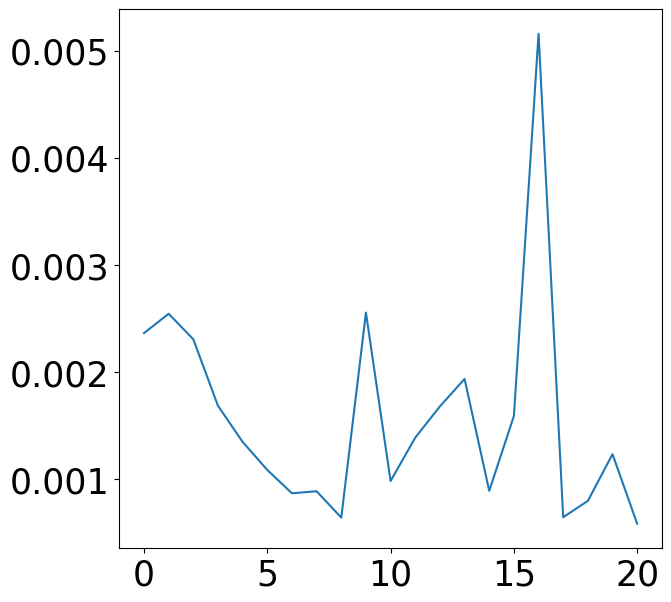

In [55]:
pl.plot(np.array(df_best['loss'])[0])

In [56]:
# df_best = df_best[ df_best['r2'] == R2]
lr_b = float(df_best['lr'])
lf_b = int(df_best['lf'])
bs_b = int(df_best['bs'])
dp_b = float(df_best['dp'])
model_b = str(np.array(df_best['model'])[0])
label_b = str(np.array(df_best['label'])[0])

best_deep_model_name = f'./model/deepgn/train/photo_lr{lr_b}_e100_b{bs_b}_lf{lf_b}_d{dp_b}_{model_b}/{label_b}/model_checkpoint_best.pt'
print(best_deep_model_name)

./model/deepgn/train/photo_lr0.1_e100_b32_lf3_d0.3_resnet152/Z0.6Guada/model_checkpoint_best.pt


In [57]:
best_deep_model_name = f'./model/deepgn/train/photo_lr{lr_b}_e100_b{bs_b}_lf{lf_b}_d{dp_b}_{model_b}/{label_b}/model_checkpoint_best.pt'
print(best_deep_model_name)

model = GalaxyNet(modelname=model_b, lf=lf_b)

checkpoint = torch.load(best_deep_model_name)
print(checkpoint['epoch'])
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

Y_pred, Y_test = evaluate(test_dataloader, model)

./model/deepgn/train/photo_lr0.1_e100_b32_lf3_d0.3_resnet152/Z0.6Guada/model_checkpoint_best.pt
30
cuda:0


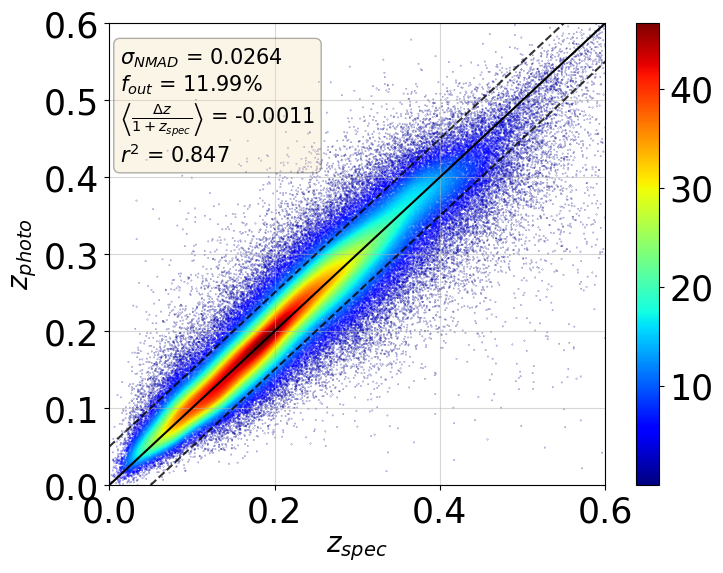

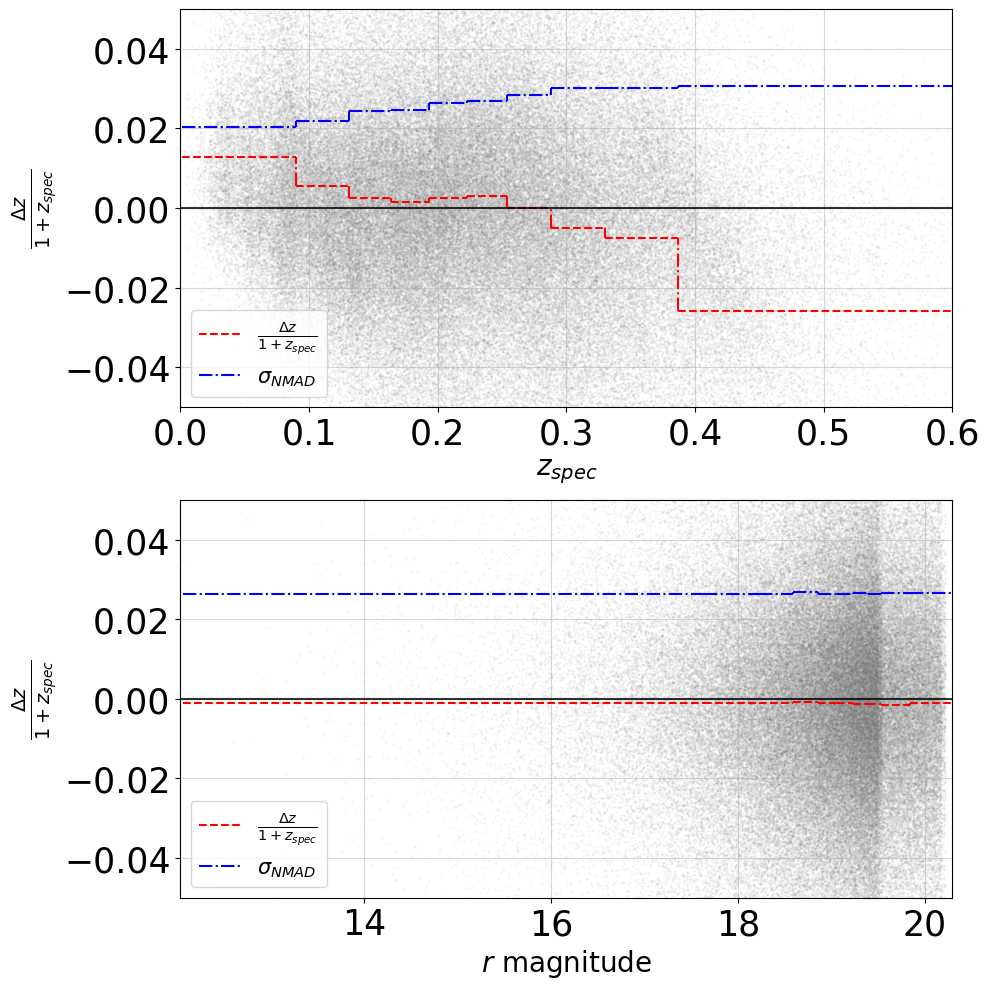

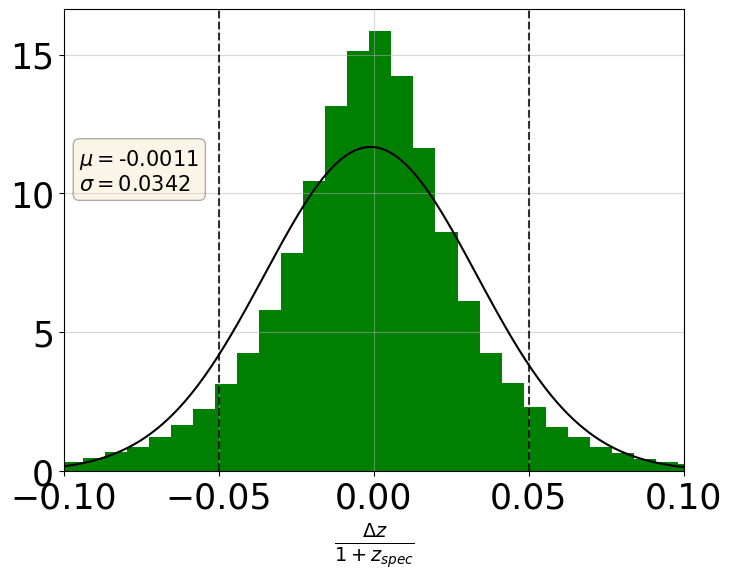

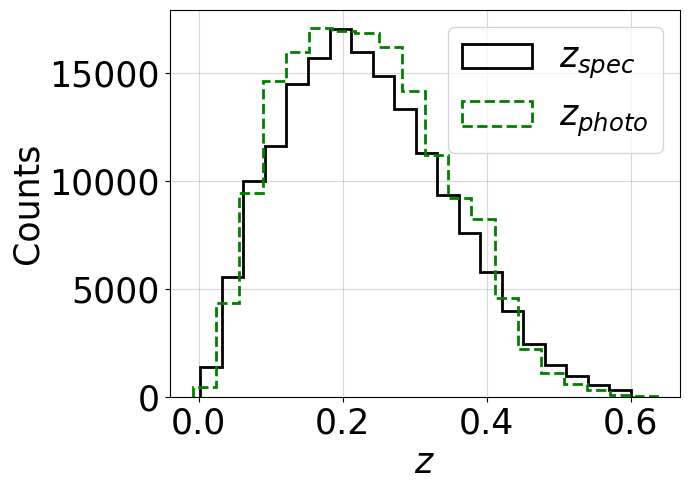

In [58]:
avg_bias, var_bias, std_bias, sigma_nmad, f_out, r2, zspec, zphoto = model_plot( Y_pred, Y_test, 'paper_figs', 'fig4_PhotoDbest')

In [60]:
last_deep_model_name = np.sort(glob(f'./model/deepgn/train/photo_lr{lr_b}_e100_b{bs_b}_lf{lf_b}_d{dp_b}_{model_b}/{label_b}/model_checkpoint_e*.pt'))[-1]
print(last_deep_model_name)

model = GalaxyNet(modelname = model_b, lf=lf_b)

checkpoint = torch.load(last_deep_model_name)
print(checkpoint['epoch'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#print(device)
model = model.to(device)

Y_pred_last, Y_test_last = evaluate(test_dataloader, model)

./model/deepgn/train/photo_lr0.1_e100_b32_lf3_d0.3_resnet152/Z0.6Guada/model_checkpoint_e033.pt
33


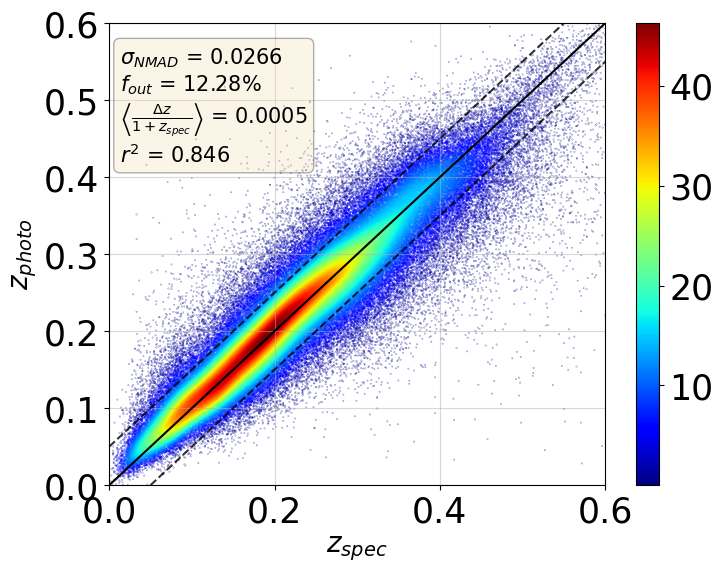

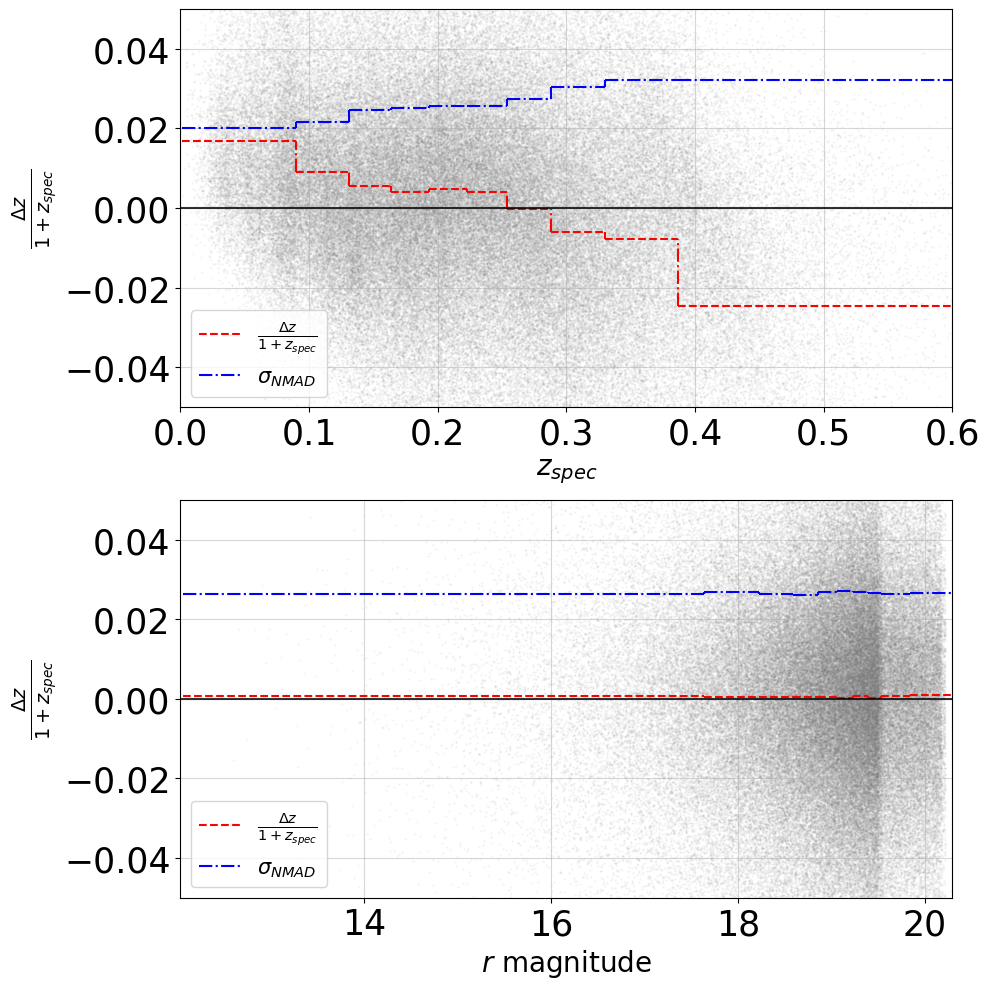

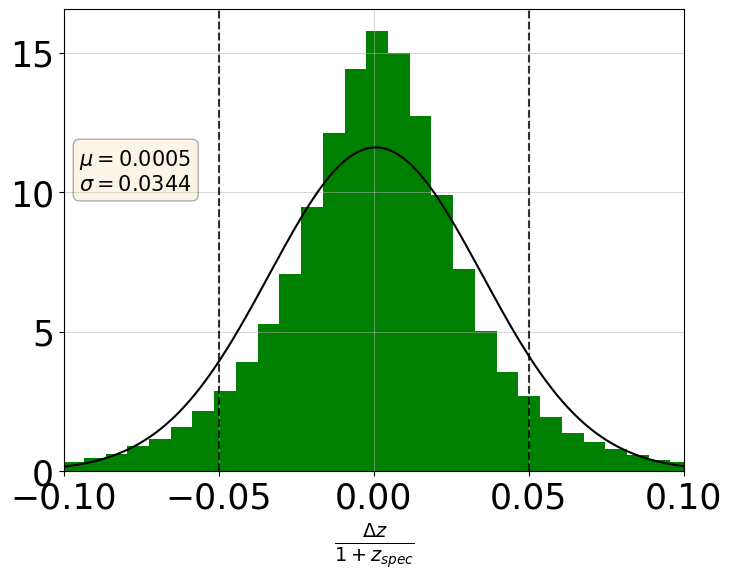

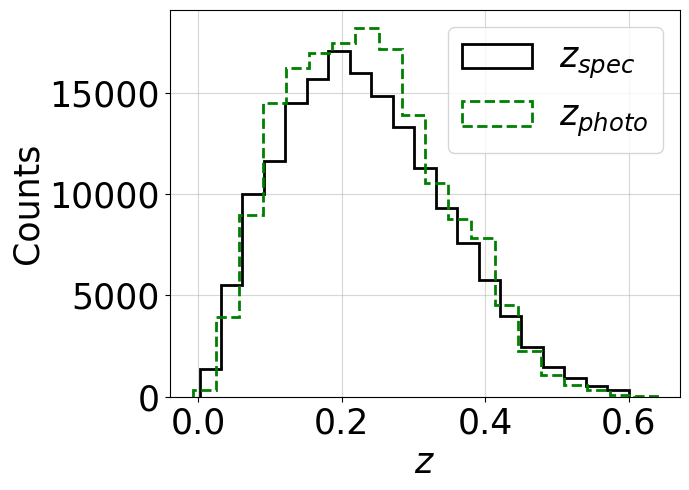

In [61]:
avg_bias, var_bias, std_bias, sigma_nmad, f_out, r2, zspec, zphoto = model_plot(Y_pred_last, Y_test_last, 'paper_figs', 'fig4_PhotoDlast')

In [17]:
bestval_deep_model_name = f'./model/deepgn/train/photo_lr0.1_e100_b64_lf3_d0.3_resnet152/Z0.6Guada/model_checkpoint_e019.pt'
print(bestval_deep_model_name)

checkpoint = torch.load(bestval_deep_model_name)
print(checkpoint['epoch'])

model = GalaxyNet(modelname='resnet152', lf=3)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#print(device)
model = model.to(device)

Y_pred_last, Y_test_last = evaluate(test_dataloader, model)

./model/deepgn/train/photo_lr0.1_e100_b64_lf3_d0.3_resnet152/Z0.6Guada/model_checkpoint_e019.pt
19


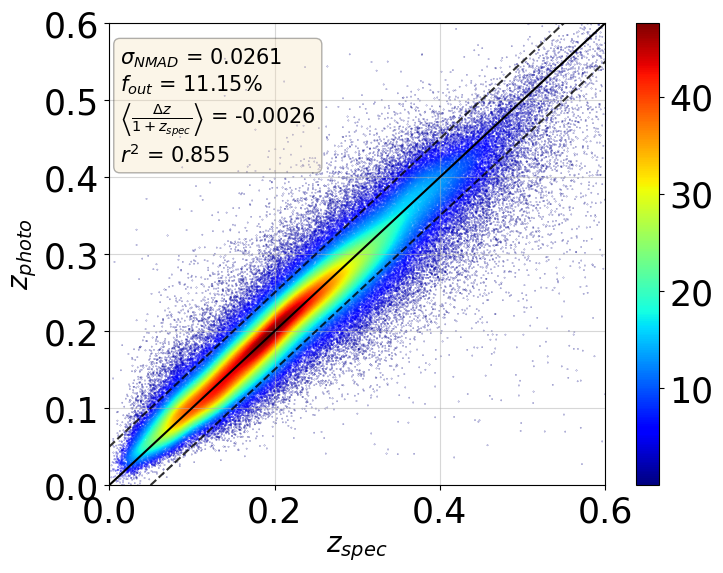

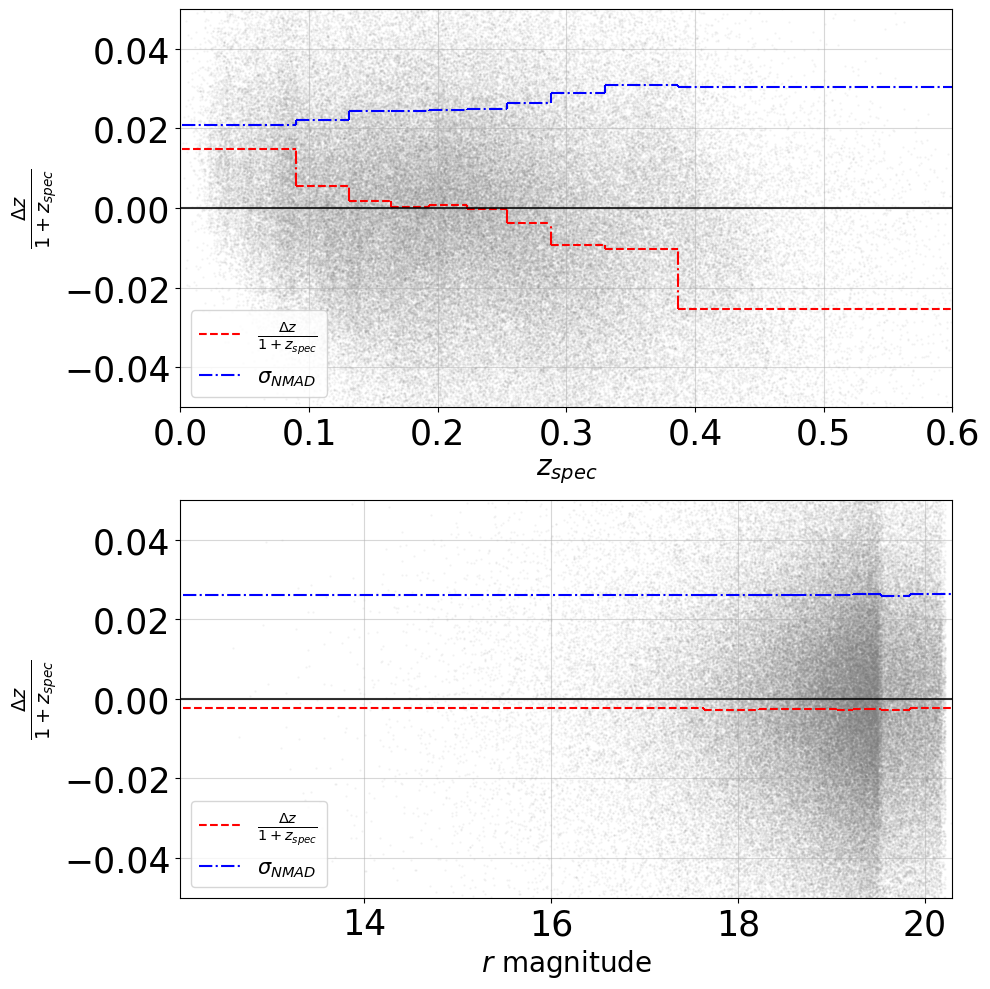

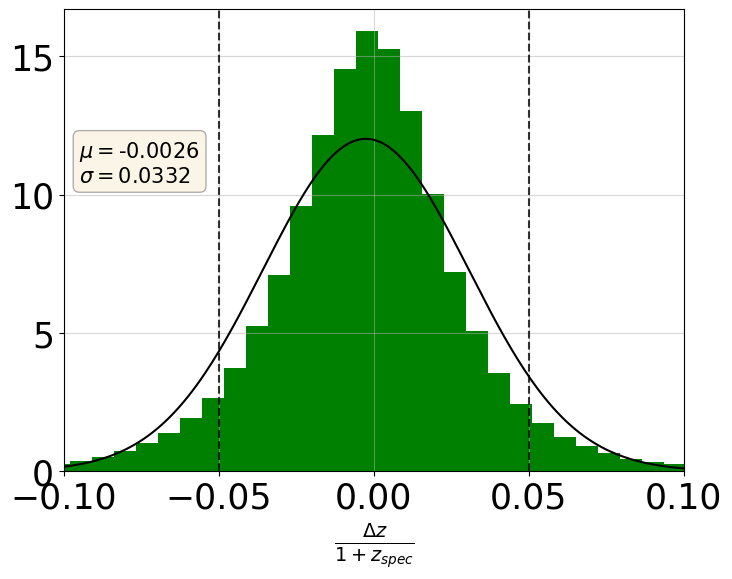

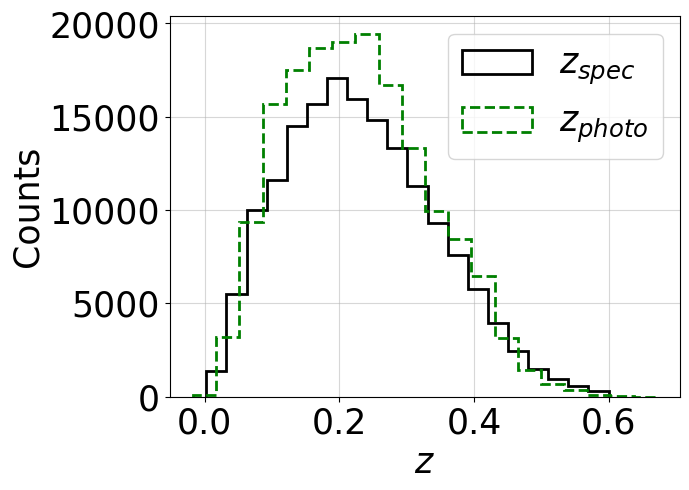

In [18]:
avg_bias, var_bias, std_bias, sigma_nmad, f_out, r2, zspec, zphoto = model_plot(Y_pred_last, Y_test_last, 'paper_figs', 'fig4_PhotoDbestval')